In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

In [ ]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts).toarray()
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class NeuralNDG(nn.Module):
    def __init__(self, K=5):
        super(NeuralNDG, self).__init__()
        self.K = K
    
    def forward(self, y_pred, y_true):
        batch_size, num_classes = y_pred.shape
                
        relevance = torch.zeros_like(y_pred)
        relevance[torch.arange(batch_size), y_true] = 1
        
        sorted_relevance = torch.gather(relevance, 1, torch.argsort(y_pred, descending=True))
        
        discounts = torch.log2(torch.arange(2, self.K+2, device=y_pred.device).float())
        dcg = torch.sum(sorted_relevance[:, :self.K] / discounts, dim=1)
        
        ideal_dcg = 1.0 / torch.log2(torch.tensor([2.0], device=y_pred.device))
        
        ndcg = dcg / ideal_dcg
        
        return -torch.mean(ndcg)

class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X_train.shape[1]
hidden_size = 256
num_classes = len(newsgroups.target_names)
model = ClassificationModel(input_size, hidden_size, num_classes)

ce_loss = nn.CrossEntropyLoss()
neural_ndg_loss = NeuralNDG(K=5)

In [ ]:
def train_model(train_loader, test_loader, model, optimizer, loss_fn, num_epochs=10, use_ndg=False, ndg_weight=0.5):
    train_losses = []
    test_losses = []
    accuracies = []
    top_k_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if use_ndg:
                ce = loss_fn(outputs, labels)
                ndg = neural_ndg_loss(outputs, labels)
                loss = (1 - ndg_weight) * ce + ndg_weight * ndg
            else:
                loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = 100 * correct / total
        
        model.eval()
        test_loss = 0
        correct = 0
        correct_top3 = 0
        correct_top5 = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                
                if use_ndg:
                    ce = loss_fn(outputs, labels)
                    ndg = neural_ndg_loss(outputs, labels)
                    test_loss += ((1 - ndg_weight) * ce + ndg_weight * ndg).item()
                else:
                    test_loss += loss_fn(outputs, labels).item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                _, top3_pred = outputs.topk(3, dim=1)
                correct_top3 += top3_pred.eq(labels.view(-1, 1).expand_as(top3_pred)).sum().item()
                
                _, top5_pred = outputs.topk(5, dim=1)
                correct_top5 += top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        accuracy = 100 * correct / total
        top3_accuracy = 100 * correct_top3 / total
        top5_accuracy = 100 * correct_top5 / total
        
        accuracies.append(accuracy)
        top_k_accuracies.append((top3_accuracy, top5_accuracy))
        
        print(f"Эпоха {epoch+1}:")
        print(f"Ошибка на обучении: {train_loss:.4f}, Ошибка на тесте: {test_loss:.4f}")
        print(f"Точность: {accuracy:.2f}%, Точность топ-3: {top3_accuracy:.2f}%, Точность топ-5: {top5_accuracy:.2f}%")
        print("----------------------------------")
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracies': accuracies,
        'top_k_accuracies': top_k_accuracies
    }

In [ ]:
print("\nЭксперимент 1: Только кросс-энтропия")
optimizer_ce = optim.Adam(model.parameters(), lr=0.001)
results_ce = train_model(train_loader, test_loader, model, optimizer_ce, ce_loss)

model = ClassificationModel(input_size, hidden_size, num_classes)

print("\nЭксперимент 2: Комбинированная функция потерь (CE + NeuralNDG)")
optimizer_combined = optim.Adam(model.parameters(), lr=0.001)
results_combined = train_model(train_loader, test_loader, model, optimizer_combined, 
                              ce_loss, use_ndg=True, ndg_weight=0.3)


Эксперимент 1: Только кросс-энтропия


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 194.60it/s]


Эпоха 1:
Ошибка на обучении: 0.1320, Ошибка на тесте: 1.2896
Точность: 68.06%, Точность топ-3: 84.16%, Точность топ-5: 90.11%
----------------------------------


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 202.30it/s]


Эпоха 2:
Ошибка на обучении: 0.1122, Ошибка на тесте: 1.3548
Точность: 67.69%, Точность топ-3: 83.77%, Точность топ-5: 89.55%
----------------------------------


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 215.18it/s]


Эпоха 3:
Ошибка на обучении: 0.1054, Ошибка на тесте: 1.4081
Точность: 67.53%, Точность топ-3: 83.53%, Точность топ-5: 89.26%
----------------------------------


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 205.27it/s]


Эпоха 4:
Ошибка на обучении: 0.1018, Ошибка на тесте: 1.4546
Точность: 67.61%, Точность топ-3: 83.40%, Точность топ-5: 88.99%
----------------------------------


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 189.58it/s]


Эпоха 5:
Ошибка на обучении: 0.1003, Ошибка на тесте: 1.5056
Точность: 67.56%, Точность топ-3: 83.26%, Точность топ-5: 89.42%
----------------------------------


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 190.01it/s]


Эпоха 6:
Ошибка на обучении: 0.0983, Ошибка на тесте: 1.5374
Точность: 67.75%, Точность топ-3: 83.10%, Точность топ-5: 88.67%
----------------------------------


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 198.78it/s]


Эпоха 7:
Ошибка на обучении: 0.0969, Ошибка на тесте: 1.5740
Точность: 67.53%, Точность топ-3: 83.45%, Точность топ-5: 88.78%
----------------------------------


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 200.91it/s]


Эпоха 8:
Ошибка на обучении: 0.0960, Ошибка на тесте: 1.5996
Точность: 66.84%, Точность топ-3: 83.08%, Точность топ-5: 88.91%
----------------------------------


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 216.74it/s]


Эпоха 9:
Ошибка на обучении: 0.0956, Ошибка на тесте: 1.6247
Точность: 67.06%, Точность топ-3: 83.10%, Точность топ-5: 88.62%
----------------------------------


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 209.68it/s]


Эпоха 10:
Ошибка на обучении: 0.0948, Ошибка на тесте: 1.6633
Точность: 66.53%, Точность топ-3: 82.89%, Точность топ-5: 88.62%
----------------------------------

Эксперимент 2: Комбинированная функция потерь (CE + NeuralNDG)


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 202.74it/s]


Эпоха 1:
Ошибка на обучении: 1.3367, Ошибка на тесте: 0.7361
Точность: 66.21%, Точность топ-3: 85.01%, Точность топ-5: 90.34%
----------------------------------


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 182.24it/s]


Эпоха 2:
Ошибка на обучении: 0.4465, Ошибка на тесте: 0.4973
Точность: 69.15%, Точность топ-3: 86.42%, Точность топ-5: 91.59%
----------------------------------


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 195.94it/s]


Эпоха 3:
Ошибка на обучении: 0.2004, Ошибка на тесте: 0.4468
Точность: 69.92%, Точность топ-3: 86.42%, Точность топ-5: 91.41%
----------------------------------


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 187.14it/s]


Эпоха 4:
Ошибка на обучении: 0.0616, Ошибка на тесте: 0.4465
Точность: 69.52%, Точность топ-3: 86.26%, Точность топ-5: 90.93%
----------------------------------


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 205.46it/s]


Эпоха 5:
Ошибка на обучении: -0.0317, Ошибка на тесте: 0.4633
Точность: 69.60%, Точность топ-3: 85.81%, Точность топ-5: 90.37%
----------------------------------


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 211.59it/s]


Эпоха 6:
Ошибка на обучении: -0.0953, Ошибка на тесте: 0.4799
Точность: 69.68%, Точность топ-3: 85.31%, Точность топ-5: 90.74%
----------------------------------


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 205.38it/s]


Эпоха 7:
Ошибка на обучении: -0.1391, Ошибка на тесте: 0.5128
Точность: 68.81%, Точность топ-3: 85.07%, Точность топ-5: 90.29%
----------------------------------


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 166.94it/s]


Эпоха 8:
Ошибка на обучении: -0.1676, Ошибка на тесте: 0.5398
Точность: 68.44%, Точность топ-3: 85.04%, Точность топ-5: 90.03%
----------------------------------


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 188.27it/s]


Эпоха 9:
Ошибка на обучении: -0.1862, Ошибка на тесте: 0.5700
Точность: 68.20%, Точность топ-3: 84.93%, Точность топ-5: 89.95%
----------------------------------


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:01<00:00, 194.49it/s]

Эпоха 10:
Ошибка на обучении: -0.1986, Ошибка на тесте: 0.5971
Точность: 68.09%, Точность топ-3: 84.72%, Точность топ-5: 90.11%
----------------------------------


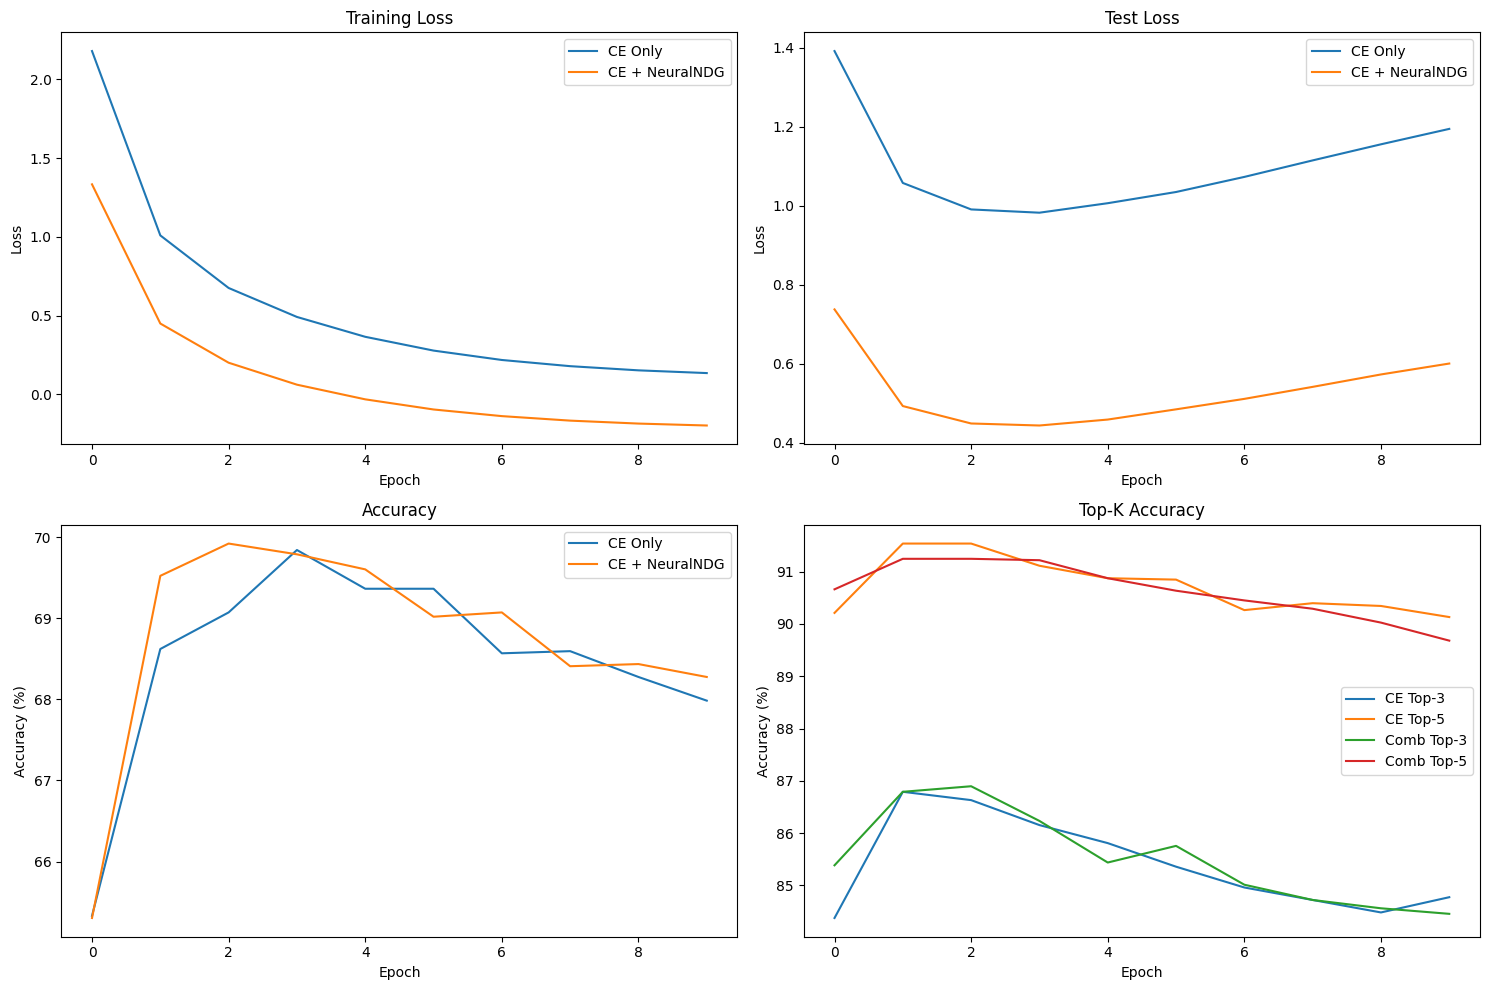

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(results_ce['train_losses'], label='CE Only')
plt.plot(results_combined['train_losses'], label='CE + NeuralNDG')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test losses
plt.subplot(2, 2, 2)
plt.plot(results_ce['test_losses'], label='CE Only')
plt.plot(results_combined['test_losses'], label='CE + NeuralNDG')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_ce['accuracies'], label='CE Only')
plt.plot(results_combined['accuracies'], label='CE + NeuralNDG')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(2, 2, 4)
top3_ce, top5_ce = zip(*results_ce['top_k_accuracies'])
top3_comb, top5_comb = zip(*results_combined['top_k_accuracies'])
plt.plot(top3_ce, label='CE Top-3')
plt.plot(top5_ce, label='CE Top-5')
plt.plot(top3_comb, label='Comb Top-3')
plt.plot(top5_comb, label='Comb Top-5')
plt.title('Top-K Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('results.png')
plt.show()

In [ ]:
final_metrics = {
    "Только CE": {
        "Точность": results_ce['accuracies'][-1],
        "Точность топ-3": results_ce['top_k_accuracies'][-1][0],
        "Точность топ-5": results_ce['top_k_accuracies'][-1][1],
        "Финальная ошибка обучения": results_ce['train_losses'][-1],
        "Финальная ошибка теста": results_ce['test_losses'][-1]
    },
    "CE + NeuralNDG": {
        "Точность": results_combined['accuracies'][-1],
        "Точность топ-3": results_combined['top_k_accuracies'][-1][0],
        "Точность топ-5": results_combined['top_k_accuracies'][-1][1],
        "Финальная ошибка обучения": results_combined['train_losses'][-1],
        "Финальная ошибка теста": results_combined['test_losses'][-1]
    }
}

print("\nФинальные результаты:")
for model_name, metrics in final_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        if "Точность" in metric_name:
            print(f"{metric_name}: {value:.2f}%")
        else:
            print(f"{metric_name}: {value:.4f}")

print("\nАнализ по классам:")
model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_top5 = defaultdict(int)

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, top5_pred = outputs.topk(5, dim=1)
        
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            class_correct[label] += (predicted[i] == label).item()
            class_top5[label] += top5_pred[i].eq(label).sum().item()

print("\nТочность топ-1 по классам:")
for i in range(num_classes):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{newsgroups.target_names[i]:25s}: {acc:.2f}%")

print("\nТочность топ-5 по классам:")
for i in range(num_classes):
    acc = 100 * class_top5[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{newsgroups.target_names[i]:25s}: {acc:.2f}%")


Финальные результаты:

Только CE:
Точность: 66.53%
Точность топ-3: 82.89%
Точность топ-5: 88.62%
Финальная ошибка обучения: 0.0948
Финальная ошибка теста: 1.6633

CE + NeuralNDG:
Точность: 68.09%
Точность топ-3: 84.72%
Точность топ-5: 90.11%
Финальная ошибка обучения: -0.1986
Финальная ошибка теста: 0.5971

Анализ по классам:

Точность топ-1 по классам:
alt.atheism              : 56.95%
comp.graphics            : 62.87%
comp.os.ms-windows.misc  : 55.38%
comp.sys.ibm.pc.hardware : 61.20%
comp.sys.mac.hardware    : 66.34%
comp.windows.x           : 75.81%
misc.forsale             : 71.50%
rec.autos                : 71.43%
rec.motorcycles          : 65.48%
rec.sport.baseball       : 80.09%
rec.sport.hockey         : 84.34%
sci.crypt                : 70.65%
sci.electronics          : 60.40%
sci.med                  : 81.96%
sci.space                : 74.07%
soc.religion.christian   : 73.27%
talk.politics.guns       : 67.02%
talk.politics.mideast    : 71.43%
talk.politics.misc       : 59.1